# Plan


Задача: Бинарная классификация срезов (есть опухоль/нет опухоли)

0. Load sample data
1. Setup VGG-like architecture
2. Simple DataLoader
3. Patch sampling & data augmentation
4. Batch training
5. Tensorboard

# 0. Load sample data

In [1]:
import nibabel
from pathlib import Path
from dpipe.im.visualize import slice3d

In [2]:
data_folder = Path('/home/anvar/work/data/MICCAI_BraTS2020_TrainingData/')

In [3]:
len(list(data_folder.glob('*')))

369

In [4]:
for subdir in data_folder.glob('*'):
    file = subdir.stem
    img = nibabel.load(subdir / f'{file}_flair.nii.gz').get_fdata()
    mask = nibabel.load(subdir / f'{file}_seg.nii.gz').get_fdata()
    break

In [5]:
img.shape, mask.shape

((240, 240, 155), (240, 240, 155))

In [6]:
slice3d(img, mask)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=154), Output()), _dom…

In [7]:
import numpy as np

In [15]:
np.zeros((5,5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [18]:
np.sum(mask, axis=(0,1)).astype(bool)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [8]:
np.nonzero(np.sum(mask, axis=(0,1)))

(array([ 57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137]),)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
img[..., 50].shape

(240, 240)

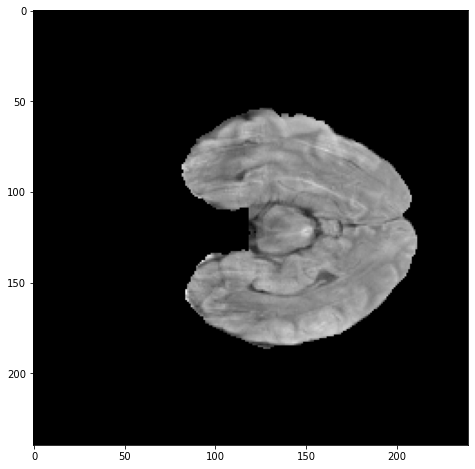

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(img[..., 50], cmap='gray');

# 1. Setup VGG-like architecture

More examples https://github.com/bentrevett/pytorch-image-classification/

![title](https://camo.githubusercontent.com/fed0475719a58ed51683e32c5fc4157051d1ba44/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f7667672e706e673f7261773d31)

In [24]:
import torch
import torch.nn as nn
from torch.nn import Sequential

`nn.Module` https://pytorch.org/docs/stable/generated/torch.nn.Module.html это базовый класс для определения архитектуры нейронной сети. От него следует наследовать любой класс определяющий нейронную сеть.

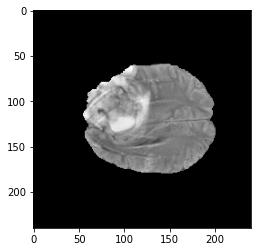

In [31]:
plt.imshow(img[..., 100], cmap='gray')

In [62]:
conv = nn.Conv2d(1, 5, 3, padding=1).float()


# kernel_size, padding, stride    #, dilation

In [71]:
img_slice = img[..., 100]
img_slice = img_slice.reshape(1, 1, 240, 240)
img_slice = torch.from_numpy(img_slice).float()

In [66]:
img_after_conv = conv(img_slice)

In [67]:
img_after_conv.shape

torch.Size([1, 5, 240, 240])

Количество объектов x Количество каналов x Высота x Ширина

In [74]:
img_slice = img[..., 100]
img_slice = img_slice.reshape(1, 1, 240, 240)
img_slice = torch.from_numpy(img_slice).float()

img_slice.shape

torch.Size([1, 1, 240, 240])

In [82]:
conv1 = nn.Conv2d(1, 5, 3, padding=1).float()
conv2 = nn.Conv2d(5, 10, 3, padding=1).float()

# x = conv1(x)
# x = conv2(x)
# x = conv3(x)

# x = conv2(conv1(x))

conv_seq = Sequential(
                nn.Conv2d(1, 5, 3, padding=1),
                nn.Conv2d(5, 10, 3, padding=1),
                nn.Conv2d(10,12, 3, padding=1)
            ).float()


c1 = nn.Conv2d(1, 5, 3, padding=1)
c2 = nn.Conv2d(5, 10, 3, padding=1)
c3 = nn.Conv2d(10,12, 3, padding=1)


conv_seq = Sequential(
                c1,
                c2,
                c3
            ).float()

In [83]:
y1 = conv_seq(img_slice)

y2 = c3(c2(c1(img_slice)))

y3 = c1(img_slice)
y3 = c2(y3)
y3 = c3(y3)

# 1, 12, 240, 240

In [86]:
torch.allclose(y3, y1)

True

In [88]:
torch.all(y1 == y3)

tensor(True)

In [89]:
0.12481982912412411 == 0.12481982912412412

False

In [90]:
np.allclose(0.12481982912412411,0.12481982912412412)

True

In [94]:
img_slice = img[..., 100]
img_slice = img_slice.reshape(1, 1, 240, 240)
img_slice = torch.from_numpy(img_slice).float()

img_slice.shape

torch.Size([1, 1, 240, 240])

In [140]:
conv_seq = Sequential(
                nn.Conv2d(1, 5, 3, padding=1),
#                 nn.Conv2d(5, 10, 3, padding=1),
#                 nn.Conv2d(10, 12, 3, padding=1),
                nn.MaxPool2d(2, stride=2, padding=0),
#                 nn.AdaptiveMaxPool2d(30)
            ).float()


linear = nn.Linear(12*30*30, 10).float()

In [141]:
maxpool = nn.MaxPool2d(2, stride=2, padding=0).float()

In [142]:
# random_img = torch.rand(1, 1, 180, 180)

# img_after_conv = conv_seq(random_img)


img_after_conv = conv_seq(img_slice)

# linear(img_after_conv.view(1, -1))

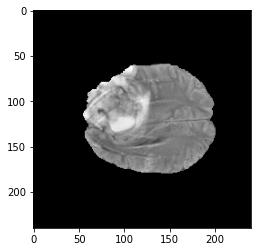

In [143]:
plt.imshow(img_slice[0, 0, ...].detach(),cmap='gray')

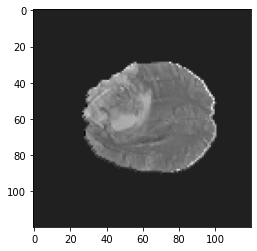

In [144]:
plt.imshow(img_after_conv[0, 3, ...].detach(),cmap='gray')

In [ ]:
class VGGNet(nn.Module):
    def __init__(self):
        super().__init__() # super(VGGNet, self).__init__()
        pass
    
    def forward(self, x):
        return x

net = VGGNet()

In [ ]:
c1 = nn.Conv2d(1, 5, 3, stride=1, padding=1).double()
c2 = nn.Conv2d(5, 10, 3, stride=1, padding=1).double()
m3 = nn.MaxPool2d((7,7), stride=(7,7))

In [ ]:
img_1.shape

In [ ]:
conv_seq2 = Sequential(
    c1, c2, m3
)

In [ ]:
img_after_2_conv = conv_seq2(img_1)

# y = c1(img_1)
# y = c2(y)

In [ ]:
img_after_2_conv.view(img_after_2_conv.shape[0], -1).shape

`nn.Sequential` https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html это аналог `sklearn.pipeline.Pipeline` это функция, которая последовательно исполняет все функции переданные ей на вход:

```
g = Sequential(a, b, c)
g(x) эквивалентно c(b(a(x)))
```

In [147]:
def conv3x3(in_channels, out_channels, stride=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1)),
        nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True)
    ]

class VGGNet(nn.Module):
    def __init__(self):
        super().__init__()
        # VGG11 # VGG9
        self.features = Sequential(
            *conv3x3(1, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 32),
            *conv3x3(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            *conv3x3(32, 64),
            *conv3x3(64, 64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(5)

        self.classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

net = VGGNet()

In [145]:
# Распаковка аргументов

a = [1, 2, 3]


b = [*a, 4, 5, 6]
c = [a, 4, 5, 6]

print(b)
print(c)

[1, 2, 3, 4, 5, 6]
[[1, 2, 3], 4, 5, 6]


In [185]:
rand_tensor = torch.rand((1, 1, 180, 180))

# Кол-во наблюдений x Кол-во каналов x Кол-во пикселей X x Кол-во пикселей Y

In [186]:
sigm = nn.Sigmoid()

In [187]:
sigm(net.forward(rand_tensor))

tensor([[0.5644]], grad_fn=<SigmoidBackward>)

# 2. DataLoader

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get `i`

In [195]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
for batch in range(100):
    images, y = load_image(batch)
    train_network(images, y)

In [190]:
class A:
    def __len__(self,):
        return 1

a = A()

In [193]:
len(a)

1

In [ ]:
a[5]

In [196]:
class BraTSDataset(Dataset):
    
    def __init__(self, source_folder: [str, Path], transform=None):
        if isinstance(source_folder, str):
            source_folder = Path(source_folder)
            
        self.images = sorted(list(source_folder.glob('*')))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        
        file_name = self.images[i].stem
        image = nibabel.load(self.images[i] / f'{file_name}_flair.nii.gz').get_fdata()
        mask = nibabel.load(self.images[i] / f'{file_name}_seg.nii.gz').get_fdata()
        sample = image, mask
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [197]:
Path('/home/anvar/work/data/MICCAI_BraTS2020_TrainingData/').stem

'MICCAI_BraTS2020_TrainingData'

In [198]:
data_folder = Path('/home/anvar/work/data/MICCAI_BraTS2020_TrainingData/')
# sorted(list(data_folder.glob('*')))
dataset = BraTSDataset(data_folder)

In [213]:
img, mask = dataset[7]

In [214]:
img.shape, mask.shape

# plt.imshow(img[..., 50])

((240, 240, 155), (240, 240, 155))

# 3. Patch sampling & data augmentation

In [215]:
from torchvision import transforms
import numpy as np

In [216]:
def random_slice(sample):
    image, mask = sample
    nonzero = np.nonzero(np.sum(image, (0, 1)))[0]
    np.random.shuffle(nonzero)
    k = nonzero[0]
    return image[..., k], mask[..., k]

def random_crop(sample):
    
    image, mask = sample
    delta_h, delta_w = 20, 20
    h, w = image.shape
    new_h, new_w = 120, 120
    top = np.random.randint(0, h - delta_h - new_h)
    left = np.random.randint(0, w - delta_w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]
    
    mask = mask[top: top + new_h,
                  left: left + new_w]
    
    return image, mask.sum(axis=0).sum(axis=0).astype(bool)

def to_tensor(sample):
    image, target = sample
    image = image.reshape(1, image.shape[0], image.shape[1])
    return torch.from_numpy(image), target

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

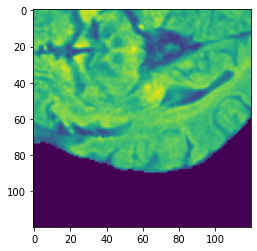

In [237]:
# _img, _mask = random_slice([img, mask])
_img2, y = random_crop([_img, _mask])

plt.imshow(_img2);

In [ ]:
x = f1(x)
x = f2(x)
...

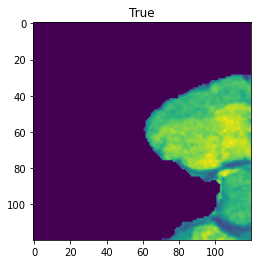

In [239]:
data_transform = transforms.Compose([
                    random_slice,
                    random_crop,
                    to_tensor
            ])

_img, y = data_transform([img, mask])
plt.imshow(_img[0])
plt.title(y);

In [240]:
data_transform = transforms.Compose([
                    random_slice,
                    random_crop,
                    to_tensor
            ])
brats_dataset = BraTSDataset(data_folder, transform=data_transform)

In [242]:
im, y = brats_dataset[10]

In [243]:
im.shape

torch.Size([1, 120, 120])

In [244]:
y

False

In [245]:
dataset_loader = torch.utils.data.DataLoader(brats_dataset,
                                             batch_size=8, shuffle=True,
                                             num_workers=8)

In [248]:
for imgs, ys in dataset_loader:
    break

In [247]:
imgs.shape

torch.Size([8, 1, 120, 120])

In [ ]:
8 x 1 x 240 x 240 x 155

In [ ]:
155 

In [ ]:
8 x 120 x 120

In [ ]:
8 x 240 x 240 x 155


# 4. Batch training (training loop)

# 5. Tensorboard